In [1]:
import pandas as pd
import numpy as np
import yaml
import gzip
import re
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import HTML 
#sckit learn

from sklearn.preprocessing  import StandardScaler, OneHotEncoder
from sklearn.manifold import MDS 
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from data_processor import DataProcessor
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score


### <span style="background-color: lightyellow;">Data retrieval task</span>
- Retrieve the data. (No cleaning needed yet)

In [2]:

def get_config(file_name):

    with open(file_name, 'r', encoding="UTF-8") as stream:
        config = yaml.safe_load(stream)
    return config


def parse_metadata(file_path):
    data = {}
    with gzip.open(file_path, 'rt') as f:
        lines = f.readlines()

    for line in lines:
        splited = line.split('\t', 1)
        if len(splited) >= 2:
            # Only include lines where the first part is '!Sample_title' or does not start with '!'
            if splited[0].strip() == '!Sample_title' or not splited[0].lstrip().startswith('!'):
                data[splited[0].strip()] = splited[1].strip().strip(
                    '"').split("\t")

    df = pd.DataFrame.from_dict(data, orient='index').transpose()
    df.drop(columns=['!Sample_title'], inplace=True)
    df.drop('"ID_REF"', inplace=True, axis=1)
    df = df.apply(pd.to_numeric, errors='coerce')
    return df


def retrieve_data():

    config = get_config('config.yaml')
    lung3 = config['lung3_csv']
    gene = config['gene']

    lung3_df = pd.read_csv(lung3)
    gene_expression_df = parse_metadata(gene)

    combined_df = lung3_df.merge(gene_expression_df, left_index=True,right_index=True)
    
    return combined_df

def sub_classification(histology):
    if "Carcinoma" in histology:
        return 'Carcinoma'
    elif "Adenocarcinoma" in histology:
        return 'Adenocarcinoma'
    else:
        return 'Others'
    


### <span style="background-color: lightyellow;">Feature engineering Task</span>




In [3]:

class FeatureProcessing(TransformerMixin, BaseEstimator): 
    def __init__(self, covariance_threshold=0, quantile_percentage=95, nan_threshold =35):
        self.covariance_threshold = covariance_threshold
        self.quantile_percentage = quantile_percentage
        self.nan_threshold= nan_threshold
        
    def fit(self, X, y=None):
        
        data_processor = DataProcessor(X)
        data_processor.remove_nonrelated_columns()
        data_processor.impute_notavailable_values('characteristics.tag.grade')
        data_processor.drop_nan_columns(self.nan_threshold)
        # data_processor.change_column_datatype()
        
        data_processor.cramerV(y, self.covariance_threshold)
        self.covarrianced_columns = data_processor.covarrianced_columns
        removed_catagorical_features = set(data_processor.find_cols_on_type('object')) - set(self.covarrianced_columns)
        data_processor.drop_columns(column_list = list(removed_catagorical_features))
        data_processor.selecting_high_variance_gene_expression(self.quantile_percentage)
        self.features = data_processor.dataframe.columns
        
        self.scaler = StandardScaler()
        self.scaler.fit(data_processor.dataframe[data_processor.find_cols_on_type('float64')])
        
        self.one_hot_encoder= OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        self.one_hot_encoder.fit(data_processor.dataframe[data_processor.covarrianced_columns])
        self.processed_df = data_processor.dataframe
        return self
    
    def transform(self, X):
    
       data_processor = DataProcessor(X)
       data_processor.dataframe = data_processor.dataframe[self.features]
       data_processor.fit_standard_scaling(self.scaler)
       data_processor.encoding_catagorical_features(self.one_hot_encoder, self.covarrianced_columns)
       data_processor.dataframe.fillna(0, inplace=True)
       
       X = data_processor.dataframe

       return X




### <span style="background-color: lightyellow;">Evaluation Task</span>

In [4]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

class Evaluator:
    def __init__(self, model,):
        pass
        
    @staticmethod
    def eval(y_pred, test_y, print_result = False):
        
        accuracy = accuracy_score(test_y, y_pred)

        if print_result:
            report = classification_report(test_y, y_pred, zero_division=0)
            matrix = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_pred, test_y))
            print("Model testing complete.")
            print(f"Accuracy: {accuracy}")
            print("\nClassification Report:\n", report)
            print("\nMatrix:\n")
            matrix.plot()

        return accuracy



### <span style="background-color: lightyellow;">Pipeline Task</span>


In [6]:
from sklearn.preprocessing import LabelEncoder
from codecarbon import track_emissions
def return_train_test_split():
    encoder = LabelEncoder()
    X = retrieve_data()
    y = X['characteristics.tag.histology'].apply(lambda x: sub_classification(x))
    y_encoded = pd.DataFrame(encoder.fit_transform(y),columns=['classes']).classes
    X.drop(columns='characteristics.tag.histology',inplace=True)

    # Before doing any preprocessing steps we will split the data into train and test inorder to prevent data leakage
    train_X, test_X, train_y, test_y = train_test_split(X, y_encoded, random_state=42)


    test_y.reset_index(drop=True, inplace = True)
    train_y.reset_index(drop=True, inplace = True)
    return train_X, test_X, train_y, test_y
    


In [7]:
@track_emissions
def run_feature_processing():
    train_X, test_X, train_y, test_y = return_train_test_split()
    print("###### Feature processing ######")
    fp = FeatureProcessing()
    fp.fit(train_X,train_y)
    x = fp.transform(train_X)
    
run_feature_processing()

[codecarbon INFO @ 00:08:15] [setup] RAM Tracking...
[codecarbon INFO @ 00:08:15] [setup] GPU Tracking...
[codecarbon INFO @ 00:08:15] No GPU found.
[codecarbon INFO @ 00:08:15] [setup] CPU Tracking...
[codecarbon WARNING @ 00:08:15] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 00:08:17] We saw that you have a Intel(R) Xeon(R) Gold 6248 CPU @ 2.50GHz but we don't know it. Please contact us.
[codecarbon INFO @ 00:08:17] CPU Model on constant consumption mode: Intel(R) Xeon(R) Gold 6248 CPU @ 2.50GHz
[codecarbon INFO @ 00:08:17] >>> Tracker's metadata:
[codecarbon INFO @ 00:08:17]   Platform system: Linux-6.1.0-31-amd64-x86_64-with-glibc2.36
[codecarbon INFO @ 00:08:17]   Python version: 3.12.3
[codecarbon INFO @ 00:08:17]   CodeCarbon version: 2.2.2
[codecarbon INFO @ 00:08:17]   Available RAM : 880.353 GB
[codecarbon INFO @ 00:08:17]   CPU count: 80
[codecarbon INFO @ 00:08:17]   CPU model: Intel(R) Xeon(R) Gold 6248 CPU @ 2.50GHz
[codecarbon INF

###### Feature processing ######


[codecarbon INFO @ 00:08:35] Energy consumed for RAM : 0.001393 kWh. RAM Power : 330.13251399993896 W
[codecarbon INFO @ 00:08:37] Energy consumed for all CPUs : 0.000203 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:08:37] 0.001596 kWh of electricity used since the beginning.
/homes/rmeshita/Documents/Programming_6/Green_ML/data_processor.py:116: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cramer.fillna(value=0, inplace=True)
[codecarbon INFO @ 00:08:37] 
Graceful stopping: collecting and writing information.
Please wait a few seconds...
[codecarbon INFO @ 00:08:37] Energy consumed for RAM : 0.001428 kWh. RAM Power : 330.13251399993896 W
[codecarbon INFO @ 00:08:37] Energy consumed for all CPUs : 0.000208 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:08:3

[codecarbon INFO @ 12:42:07] [setup] RAM Tracking...
[codecarbon INFO @ 12:42:07] [setup] GPU Tracking...
[codecarbon INFO @ 12:42:07] No GPU found.
[codecarbon INFO @ 12:42:07] [setup] CPU Tracking...
[codecarbon WARNING @ 12:42:07] No CPU tracking mode found. Falling back on CPU constant mode.


[codecarbon WARNING @ 12:42:08] We saw that you have a Intel(R) Xeon(R) Gold 6248 CPU @ 2.50GHz but we don't know it. Please contact us.
[codecarbon INFO @ 12:42:08] CPU Model on constant consumption mode: Intel(R) Xeon(R) Gold 6248 CPU @ 2.50GHz
[codecarbon INFO @ 12:42:08] >>> Tracker's metadata:
[codecarbon INFO @ 12:42:08]   Platform system: Linux-6.1.0-31-amd64-x86_64-with-glibc2.36
[codecarbon INFO @ 12:42:08]   Python version: 3.12.3
[codecarbon INFO @ 12:42:08]   CodeCarbon version: 2.2.2
[codecarbon INFO @ 12:42:08]   Available RAM : 880.353 GB
[codecarbon INFO @ 12:42:08]   CPU count: 80
[codecarbon INFO @ 12:42:08]   CPU model: Intel(R) Xeon(R) Gold 6248 CPU @ 2.50GHz
[codecarbon INFO @ 12:42:08]   GPU count: None
[codecarbon INFO @ 12:42:08]   GPU model: None


###### Model: XGboost ######


[codecarbon INFO @ 12:42:28] Energy consumed for RAM : 0.001469 kWh. RAM Power : 330.13251399993896 W
[codecarbon INFO @ 12:42:28] Energy consumed for all CPUs : 0.000200 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:42:28] 0.001669 kWh of electricity used since the beginning.
/homes/rmeshita/Documents/Programming_6/Green_ML/data_processor.py:116: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cramer.fillna(value=0, inplace=True)


Model testing complete.
Accuracy: 0.8695652173913043

Classification Report:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90         9
           1       0.91      0.91      0.91        11
           2       1.00      0.33      0.50         3

    accuracy                           0.87        23
   macro avg       0.91      0.75      0.77        23
weighted avg       0.89      0.87      0.85        23


Matrix:



[codecarbon INFO @ 12:42:32] 
Graceful stopping: collecting and writing information.
Please wait a few seconds...
[codecarbon INFO @ 12:42:32] Energy consumed for RAM : 0.001820 kWh. RAM Power : 330.13251399993896 W
[codecarbon INFO @ 12:42:32] Energy consumed for all CPUs : 0.000245 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:42:32] 0.002065 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:42:32] Done!



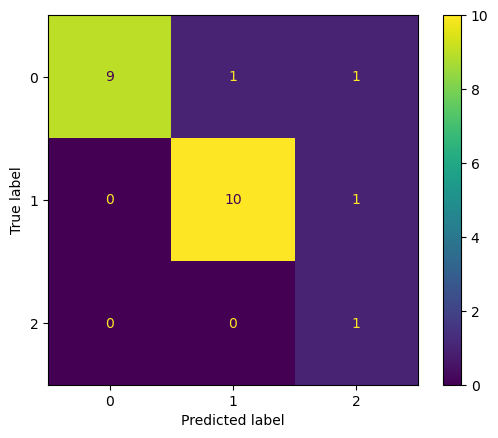

In [7]:

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import xgboost as xgb

@track_emissions
def run_xgbbost_pipeline():
    train_X, test_X, train_y, test_y = return_train_test_split()
    print("###### Model: XGboost ######")
    pipeline = Pipeline([('feature-processing', FeatureProcessing()), ('model', xgb.XGBClassifier(tree_method="hist"))])
    pipeline.fit(train_X, train_y)
    preds = pipeline.predict(test_X)
    Evaluator.eval(preds,test_y, print_result=True)

run_xgbbost_pipeline()

[codecarbon INFO @ 12:42:32] [setup] RAM Tracking...
[codecarbon INFO @ 12:42:32] [setup] GPU Tracking...
[codecarbon INFO @ 12:42:32] No GPU found.
[codecarbon INFO @ 12:42:32] [setup] CPU Tracking...
[codecarbon WARNING @ 12:42:32] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 12:42:34] We saw that you have a Intel(R) Xeon(R) Gold 6248 CPU @ 2.50GHz but we don't know it. Please contact us.
[codecarbon INFO @ 12:42:34] CPU Model on constant consumption mode: Intel(R) Xeon(R) Gold 6248 CPU @ 2.50GHz
[codecarbon INFO @ 12:42:34] >>> Tracker's metadata:
[codecarbon INFO @ 12:42:34]   Platform system: Linux-6.1.0-31-amd64-x86_64-with-glibc2.36
[codecarbon INFO @ 12:42:34]   Python version: 3.12.3
[codecarbon INFO @ 12:42:34]   CodeCarbon version: 2.2.2
[codecarbon INFO @ 12:42:34]   Available RAM : 880.353 GB
[codecarbon INFO @ 12:42:34]   CPU count: 80
[codecarbon INFO @ 12:42:34]   CPU model: Intel(R) Xeon(R) Gold 6248 CPU @ 2.50GHz
[codecarbon INF

###### Model: Gaussian NB ######


[codecarbon INFO @ 12:42:55] Energy consumed for RAM : 0.001399 kWh. RAM Power : 330.13251399993896 W
[codecarbon INFO @ 12:42:55] Energy consumed for all CPUs : 0.000214 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:42:55] 0.001613 kWh of electricity used since the beginning.
/homes/rmeshita/Documents/Programming_6/Green_ML/data_processor.py:116: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cramer.fillna(value=0, inplace=True)
[codecarbon INFO @ 12:42:55] 
Graceful stopping: collecting and writing information.
Please wait a few seconds...
[codecarbon INFO @ 12:42:55] Energy consumed for RAM : 0.001440 kWh. RAM Power : 330.13251399993896 W
[codecarbon INFO @ 12:42:55] Energy consumed for all CPUs : 0.000219 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:42:5

Model testing complete.
Accuracy: 0.8260869565217391

Classification Report:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90         9
           1       0.83      0.91      0.87        11
           2       0.00      0.00      0.00         3

    accuracy                           0.83        23
   macro avg       0.55      0.64      0.59        23
weighted avg       0.72      0.83      0.77        23


Matrix:



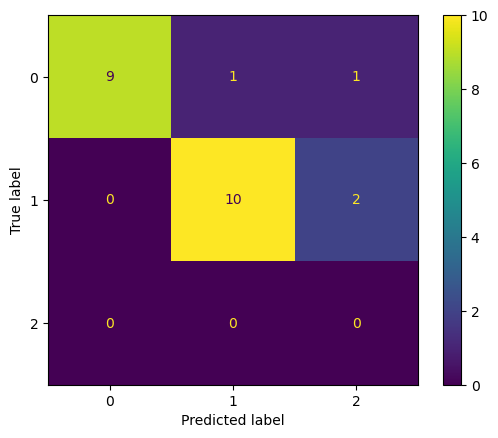

In [8]:
@track_emissions
def run_naive_bayes_pipeline():
    train_X, test_X, train_y, test_y = return_train_test_split()
    print("###### Model: Gaussian NB ######")
    pipeline1 = Pipeline([('feature-processing', FeatureProcessing()), ('model', GaussianNB())])
    pipeline1.fit(train_X, train_y)
    preds = pipeline1.predict(test_X)
    Evaluator.eval(preds,test_y, print_result=True)
run_naive_bayes_pipeline()